In [1]:
# Os imports necessários
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import urllib.request
import os.path
import pandas as pd
import glob
from PIL import Image
from tqdm.auto import tqdm
import shutil
from sklearn.model_selection import train_test_split
import yaml
import subprocess, sys
import cv2


c:\Users\Igor\anaconda3\envs\dali\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# baixando base de dados de placas de transito
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)


In [3]:
#Extraindo arquivos

# Caminho do arquivo zip
zip_path = 'GTSRB_Final_Training_Images.zip'

# Pasta onde os arquivos serão extraídos
extract_to = 'GTSRB_Final_Training_Images/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Arquivos extraídos para: {extract_to}")

KeyboardInterrupt: 

In [ ]:
# Montando dataframe pandas com coordenadas das regiões de interesse a partir dos arquivos .csv no dataset
archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
arquivos = [extract_to + file for file in archive.namelist()
              if '.csv' in file]
dfs = []

for arquivo in arquivos:
    df = pd.read_csv(arquivo, sep=";")  # ajuste o sep se necessário
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

print(df_final.shape)
print(df_final.head())

df_final.to_csv("dataset_unificado.csv", index=False, sep=";")


(39209, 8)
          Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000_00000.ppm     29      30       5       6      24      25        0
1  00000_00001.ppm     30      30       5       5      25      25        0
2  00000_00002.ppm     30      30       5       5      25      25        0
3  00000_00003.ppm     31      31       5       5      26      26        0
4  00000_00004.ppm     30      32       5       6      25      26        0


In [ ]:
# Convertendos as imagens .ppm em .png (o YOLO não tem suporte a arquivos .ppm)
GTSRB_ROOT = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"

# Caminho onde serão salvas as imagens .png
OUT_ROOT   = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images_PNG"

os.makedirs(OUT_ROOT, exist_ok=True)

ppm_files = glob.glob(os.path.join(GTSRB_ROOT, "*", "*.ppm"))

print("Total .ppm encontrados:", len(ppm_files))
for src in tqdm(ppm_files):
    rel = os.path.relpath(src, GTSRB_ROOT)
    cls_dir = os.path.dirname(rel)
    stem = os.path.splitext(os.path.basename(rel))[0]
    dst_dir = os.path.join(OUT_ROOT, cls_dir)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, f"{stem}.png")

    with Image.open(src) as im:
        im.save(dst, format="PNG")


Total .ppm encontrados: 39209


  0%|          | 0/39209 [00:00<?, ?it/s]

In [ ]:
# Adicionar imagens .png ao dataframe pandas
df = df_final.copy()

def basename_no_ext(x):
    return os.path.splitext(os.path.basename(str(x)))[0]

df["RelPathPNG"] = df.apply(
    lambda r: f"{int(r['ClassId']):05d}/{basename_no_ext(r['Filename'])}.png",
    axis=1
)

# (Opcional) Atualizar Width/Height usando a imagem PNG salva
def update_dims_from_png(row):
    png_path = os.path.join(OUT_ROOT, row["RelPathPNG"])
    if os.path.exists(png_path):
        with Image.open(png_path) as im:
            W, H = im.size
        # Se quiser forçar sempre:
        row["Width"], row["Height"] = W, H
    return row

df = df.apply(update_dims_from_png, axis=1)


In [ ]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,RelPathPNG
0,00000_00000.ppm,29,30,5,6,24,25,0,00000/00000_00000.png
1,00000_00001.ppm,30,30,5,5,25,25,0,00000/00000_00001.png
2,00000_00002.ppm,30,30,5,5,25,25,0,00000/00000_00002.png
3,00000_00003.ppm,31,31,5,5,26,26,0,00000/00000_00003.png
4,00000_00004.ppm,30,32,5,6,25,26,0,00000/00000_00004.png


In [ ]:
# Cria mapa {RelPathPNG -> caminho absoluto}
path_map = {}
png_files = glob.glob(os.path.join(OUT_ROOT, "*", "*.png"))
for p in png_files:
    rel = os.path.relpath(p, OUT_ROOT).replace("\\", "/")
    path_map[rel] = p

# Conferindo se todos os arquivos .png no dataset realmente existem no disco
missing = [rel for rel in df["RelPathPNG"].unique() if rel not in path_map]
print("Arquivos PNG faltantes no disco:", len(missing))
if missing:
    print(missing[:10])


Arquivos PNG faltantes no disco: 0


In [ ]:
# Criação dos 3 datasets: treino  validação e teste
per_image = df.groupby("RelPathPNG").agg(
    class_mode=("ClassId", lambda s: s.mode().iloc[0])
).reset_index()

# Proporções de 70%, 15% e 15% respectivamente
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
temp_ratio = val_ratio + test_ratio

train_ids, temp_ids = train_test_split(
    per_image["RelPathPNG"],
    test_size=temp_ratio,
    random_state=42,
    stratify=per_image["class_mode"]
)

temp_df = per_image[per_image["RelPathPNG"].isin(temp_ids)]
val_ids, test_ids = train_test_split(
    temp_df["RelPathPNG"],
    test_size=test_ratio / temp_ratio,
    random_state=42,
    stratify=temp_df["class_mode"]
)

df_train = df[df["RelPathPNG"].isin(train_ids)]
df_val   = df[df["RelPathPNG"].isin(val_ids)]
df_test  = df[df["RelPathPNG"].isin(test_ids)]

print("Imagens (uniq) — train/val/test:",
      df_train["RelPathPNG"].nunique(),
      df_val["RelPathPNG"].nunique(),
      df_test["RelPathPNG"].nunique())



Imagens (uniq) — train/val/test: 27446 5881 5882


In [ ]:
# Materializar pastas de imagens e labels de cada dataset
BASE = "roi_yolo_dataset"
TRAIN_IMG_DIR = os.path.join(BASE, "images/train")
VAL_IMG_DIR   = os.path.join(BASE, "images/val")
TEST_IMG_DIR  = os.path.join(BASE, "images/test")
TRAIN_LBL_DIR = os.path.join(BASE, "labels/train")
VAL_LBL_DIR   = os.path.join(BASE, "labels/val")
TEST_LBL_DIR  = os.path.join(BASE, "labels/test")

for d in [TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR, TRAIN_LBL_DIR, VAL_LBL_DIR, TEST_LBL_DIR]:
    os.makedirs(d, exist_ok=True)

def yolo_line_from_row(r):
    W = float(r["Width"]); H = float(r["Height"])
    x1, y1 = float(r["Roi.X1"]), float(r["Roi.Y1"])
    x2, y2 = float(r["Roi.X2"]), float(r["Roi.Y2"])
    x1, x2 = min(x1, x2), max(x1, x2)
    y1, y2 = min(y1, y2), max(y1, y2)
    cx, cy = (x1 + x2)/2.0, (y1 + y2)/2.0
    bw, bh = (x2 - x1), (y2 - y1)
    cls = int(r["ClassId"])
    return cls, cx/W, cy/H, bw/W, bh/H

def write_labels(split_df, labels_dir):
    written = 0
    for rel, rows in split_df.groupby("RelPathPNG"):
        stem = os.path.splitext(os.path.basename(rel))[0]
        out  = os.path.join(labels_dir, stem + ".txt")
        lines = []
        for _, r in rows.iterrows():
            cls, x, y, w, h = yolo_line_from_row(r)
            lines.append(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")
        with open(out, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        written += 1
    return written

def copy_images(relpaths, dst_dir):
    copied = 0
    for rel in relpaths:
        if rel in path_map:
            src = path_map[rel]
            dst = os.path.join(dst_dir, os.path.basename(rel))
            if os.path.abspath(src) != os.path.abspath(dst):
                shutil.copy2(src, dst)
            copied += 1
    return copied

n_train_imgs = copy_images(df_train["RelPathPNG"].unique(), TRAIN_IMG_DIR)
n_val_imgs   = copy_images(df_val["RelPathPNG"].unique(),   VAL_IMG_DIR)
n_test_imgs  = copy_images(df_test["RelPathPNG"].unique(),  TEST_IMG_DIR)

n_train_lbls = write_labels(df_train, TRAIN_LBL_DIR)
n_val_lbls   = write_labels(df_val,   VAL_LBL_DIR)
n_test_lbls  = write_labels(df_test,  TEST_LBL_DIR)

print(f"Copiadas — train/val/test: {n_train_imgs}/{n_val_imgs}/{n_test_imgs}")
print(f"Labels   — train/val/test: {n_train_lbls}/{n_val_lbls}/{n_test_lbls}")


Copiadas — train/val/test: 27446/5881/5882
Labels   — train/val/test: 27446/5881/5882


In [ ]:
# Criando arquivo data.yaml. Esse arquivo será usado para alimentar a rede YOLO
class_ids = sorted(pd.unique(df["ClassId"]).tolist())
names = [f"class_{c}" for c in class_ids]  # ou seus nomes reais

data = {
    "path": os.path.abspath(BASE),
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "names": names,
    "nc": len(names)
}
with open(os.path.join(BASE, "data.yaml"), "w", encoding="utf-8") as f:
    yaml.safe_dump(data, f, sort_keys=False, allow_unicode=True)

print("data.yaml criado com as informações dos 3 datasets.")

data.yaml criado com as informações dos 3 datasets.


In [ ]:
# Habilitando o cuda
print("CUDA:", torch.cuda.is_available())
!nvidia-smi -L

CUDA: True
GPU 0: Tesla T4 (UUID: GPU-6cefa39c-c111-4843-05f6-f217fee1c7af)


In [ ]:
# instalando ultralytics, lib que contem a YOLOv8: https://docs.ultralytics.com/pt/models/yolov8/
!pip -q install -U ultralytics opencv-python scikit-learn pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 135.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import ultralytics
print("Ultralytics:", ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics: 8.3.199


In [ ]:
# Treino
model = YOLO("yolov8n.pt")
model.train(
    data=os.path.join(BASE, "data.yaml"),
    imgsz=640,
    epochs=5,
    batch=16,
    device=0,
    project="runs_roi",
    name="yolov8n_gtsrb_png"
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=roi_yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_gtsrb_png, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea4a4e9ac00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.0

Usando: runs_roi/yolov8n_gtsrb_png/results.csv
Colunas disponíveis: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


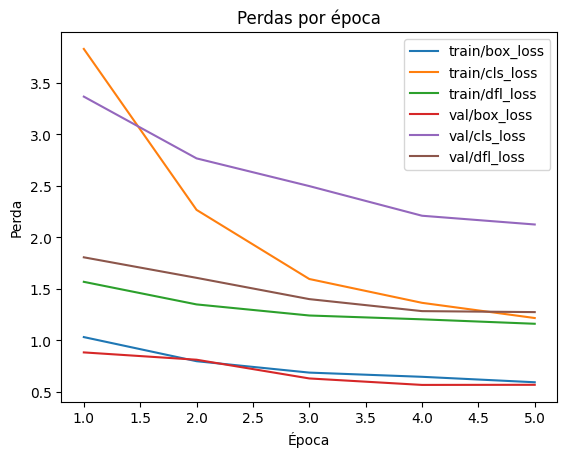

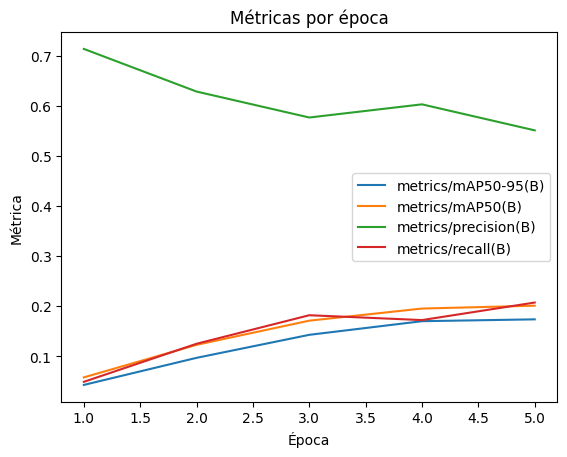

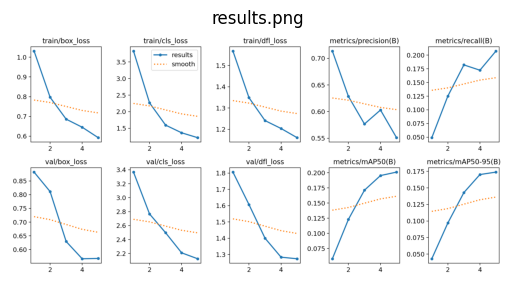

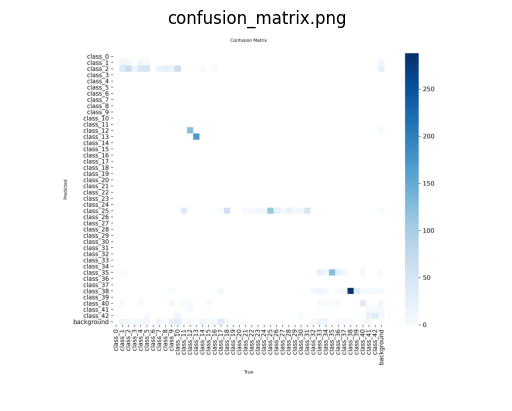

In [ ]:
# Durante o treino a lib gera algumas imagens com as métricas do treino e salva no disco. Esta célula plota essas métricas
cands = glob.glob("runs_roi/yolov8n_gtsrb_png/results.csv")
if not cands:
    raise FileNotFoundError("Não encontrei results.csv. Confira o diretório do projeto/nome do experimento.")
csv_path = max(cands, key=os.path.getmtime)
exp_dir = os.path.dirname(csv_path)
print("Usando:", csv_path)

df = pd.read_csv(csv_path)
print("Colunas disponíveis:", list(df.columns))

# Loss
loss_cols = [c for c in df.columns if "loss" in c.lower()]
if loss_cols:
    plt.figure()
    for c in loss_cols:
        plt.plot(df["epoch"], df[c], label=c)
    plt.xlabel("Época"); plt.ylabel("Perda"); plt.title("Perdas por época"); plt.legend(); plt.show()

# 4) (mAP, P, R, F1)
metric_candidates = [
    "metrics/mAP50-95(B)", "metrics/mAP50(B)", "metrics/precision(B)", "metrics/recall(B)",
    "mAP50-95", "mAP50", "precision", "recall", "fitness"
]
met_cols = [c for c in metric_candidates if c in df.columns]
if met_cols:
    plt.figure()
    for c in met_cols:
        plt.plot(df["epoch"], df[c], label=c)
    plt.xlabel("Época"); plt.ylabel("Métrica"); plt.title("Métricas por época"); plt.legend(); plt.show()

# 5) imagens de curvas prontas
img_files = ["results.png","confusion_matrix.png","PR_curve.png","P_curve.png","R_curve.png","F1_curve.png"]
for f in img_files:
    p = os.path.join(exp_dir, f)
    if os.path.exists(p):
        img = plt.imread(p)
        plt.figure()
        plt.imshow(img); plt.axis("off"); plt.title(f); plt.show()


In [ ]:
# Validação sobre o conjunto de teste
exp = max(glob.glob("runs_roi/yolov8n_gtsrb_png/"), key=os.path.getmtime)

# Usar os melhores pesos obtidos durante o treinamento
best = os.path.join(exp, "weights", "best.pt")

model = YOLO(best)
metrics_test = model.val(
    data="roi_yolo_dataset/data.yaml",
    split="test",
    imgsz=640,
    plots=True,
    save_json=True
)
print(metrics_test)


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,014,033 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 259.1±143.8 MB/s, size: 9.3 KB)
val: Scanning /content/roi_yolo_dataset/labels/test... 1878 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1878/1878 2.4Kit/s 0.8s
val: New cache created: /content/roi_yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 118/118 7.1it/s 16.6s
                   all       1878       1878      0.619      0.187      0.194      0.169
               class_1         64         64          1     0.0516      0.406      0.343
               class_2         79         79      0.226      0.873      0.468      0.401
               class_3         22         22          0          0          0          0
               class_4         49         49          1          

In [ ]:
# Predição das imagens do conjunto de teste
model.predict(
    source="roi_yolo_dataset/images/test",
    imgsz=640,
    conf=0.25,
    save=False,
    project="runs_roi",
    name="pred_test"
)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1878 /content/roi_yolo_dataset/images/test/00000_00000.png: 640x640 1 class_38, 8.7ms
image 2/1878 /content/roi_yolo_dataset/images/test/00000_00001.png: 608x640 1 class_42, 38.6ms
image 3/1878 /content/roi_yolo_dataset/images/test/00000_00002.png: 640x608 (no detections), 36.4ms
image 4/1878 /content/roi_yolo_dataset/images/test/00000_00003.png: 640x544 1 class_40, 36.5ms
image 5/1878 /content/roi_yolo_dataset/images/test/00000_00004.png: 608x

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'class_0', 1: 'class_1', 2: 'class_2', 3: 'class_3', 4: 'class_4', 5: 'class_5', 6: 'class_6', 7: 'class_7', 8: 'class_8', 9: 'class_9', 10: 'class_10', 11: 'class_11', 12: 'class_12', 13: 'class_13', 14: 'class_14', 15: 'class_15', 16: 'class_16', 17: 'class_17', 18: 'class_18', 19: 'class_19', 20: 'class_20', 21: 'class_21', 22: 'class_22', 23: 'class_23', 24: 'class_24', 25: 'class_25', 26: 'class_26', 27: 'class_27', 28: 'class_28', 29: 'class_29', 30: 'class_30', 31: 'class_31', 32: 'class_32', 33: 'class_33', 34: 'class_34', 35: 'class_35', 36: 'class_36', 37: 'class_37', 38: 'class_38', 39: 'class_39', 40: 'class_40', 41: 'class_41', 42: 'class_42'}
 obb: None
 orig_img: array([[[181, 252, 255],
         [185, 255, 255],
         [181, 252, 255],
         ...,
         [190, 255, 255],
         [192, 255, 255],
         [191, 255

In [ ]:
# Pega os resultados da predição e salva as imagens com a bounding box e a classe predita
model = YOLO("runs_roi/yolov8n_gtsrb_png/weights/best.pt")
os.makedirs("pred_custom", exist_ok=True)

for img_path in glob.glob("roi_yolo_dataset/images/test/*.png"):
    r = model(img_path)[0]  # um Results
    # Só classe (sem confiança) + fonte menor + linha fina
    im = r.plot(conf=False, labels=True, font_size=0.5, line_width=1)
    cv2.imwrite(os.path.join("pred_custom", os.path.basename(img_path)), im)

A saída de streaming foi truncada nas últimas 5000 linhas.
image 1/1 /content/roi_yolo_dataset/images/test/00010_00019.png: 640x640 1 class_40, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/roi_yolo_dataset/images/test/00055_00006.png: 640x640 1 class_38, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/roi_yolo_dataset/images/test/00033_00010.png: 608x640 1 class_40, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /content/roi_yolo_dataset/images/test/00037_00017.png: 640x640 1 class_2, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/roi_yolo_dataset/images/test/00005_00001.png: 640x640 1 class_38, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

im

In [ ]:
# Códigos e nomes das classes, para validar os resultados da predição
class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}